# **Import**

The `pycadet` package together with all the dependencies can be installed using `pip`. If you encounter issues during the installation (`tensorflow` library can sometimes be tricky to install), try solving all the [requirements](https://github.com/tomasplsek/CADET) beforehand.

In [4]:
!pip install pycadet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import center_of_mass

from pycadet import rebin, make_prediction, decompose, make_3D_cavity, CADET

2023-11-23 20:28:11.380607: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 20:28:11.400116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 20:28:11.520325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 20:28:11.520432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 20:28:11.546684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

No GPUs detected. Using a CPU.



# **Data**

The ***CADET*** pipeline inputs either raw *Chandra* images in units of counts (numbers of captured photons) or exposure-corrected images. When using exposure-corrected data, images are automatically normalized by the lowest pixel value (except for zeros) so that all pixels are higher than or equal to 1. For images with many point sources, we recommend filling the point sources with surrounding background level using Poisson statistics ([dmfilth](https://cxc.cfa.harvard.edu/ciao/ahelp/dmfilth.html) within [CIAO](https://cxc.harvard.edu/ciao/)).

Here we demonstrate the package using two exemplary images:

NGC4649.fits - image centred at the centre of the M60 galaxy, cropped to 512x512 pixels, and with filled point sources\
NGC4778.fits - exposure-corrected image of the original size of 2510x1916 pixels, includes point sources

In [4]:
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits" -O "NGC4649.fits"
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4778.fits" -O "NGC4778.fits"

--2023-11-22 21:49:25--  https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits [following]
--2023-11-22 21:49:26--  https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2462400 (2.3M) [application/octet-stream]
Saving to: ‘NGC4649.fits’

NGC4649.fits        100%[===================>]   2.35M  8.92MB/s    in 0.3s    

2023-11-22 21:49:27 (8.92 MB/s) - ‘NGC4649.fits’ saved [2462400/2462400]

--2023-11-22 21:49:27--  https://g

(529, 529)

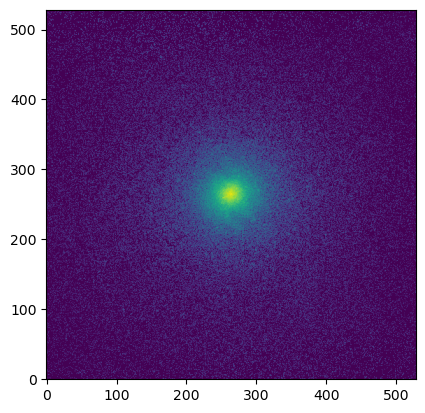

In [2]:
data = fits.getdata("NGC4649.fits")

plt.imshow(np.log10(data+1), origin="lower")

data.shape

(2510, 1916)

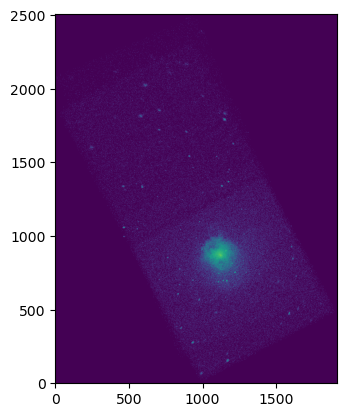

In [3]:
data = fits.getdata("NGC4778.fits")

plt.imshow(np.log10(data+1e-10), origin="lower")

data.shape

# **Rebin**

The ***CADET*** model can only input 128x128 images. Input images must therefore be cropped and binned to 128x128 pixels, which can be done using the `rebin` function. The crop size can be specified by the parameter `scale` (size = scale * 128 pixels). Images should either be centred at the galaxy center beforehand or their can be centred by specifying the `ra` and `dec` parameters. The re-binning is performed using *Astropy* and *Numpy* libraries and can only handle integer binsizes. For floating point number binning, we recommend using [dmregrid](https://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid.html).

Arguments of the `rebin` function:\
`fname` - string; name of the input file\
`scale` - integer; specifies the crop size (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)

In [4]:
from pycadet import rebin

In [5]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456")

(128, 128)

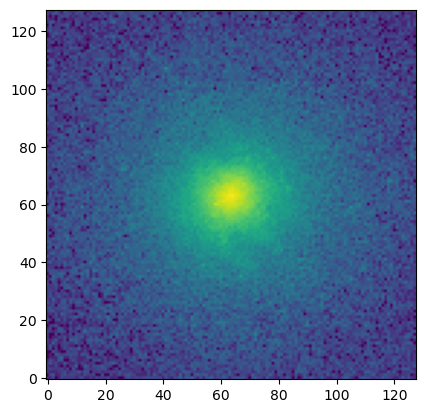

In [6]:
plt.imshow(np.log10(data+1), origin="lower")

data.shape

# **Make prediction**

The ***CADET*** model can be applied on the obtained binned image (`data`) by calling the `make_prediction` function with the binned image as an argument. On the output of this function, there is a pixel-wise prediction with values ranging from 0 to 1, which represents whether the corresponding pixel belongs to a cavity or not.

Arguments of the `make_prediction` function:\
`data` - numpy array; input image of shape (128, 128) or (130, 130) if `shift=True`\
`shift` - bool; if True, the prediction is averaged by shifting the image by +/- 1 pixel (optional, default: `shift=False`)

In [7]:
from pycadet import make_prediction

In [8]:
%time pred = make_prediction(data)

CPU times: user 7.87 s, sys: 205 ms, total: 8.07 s
Wall time: 2.1 s


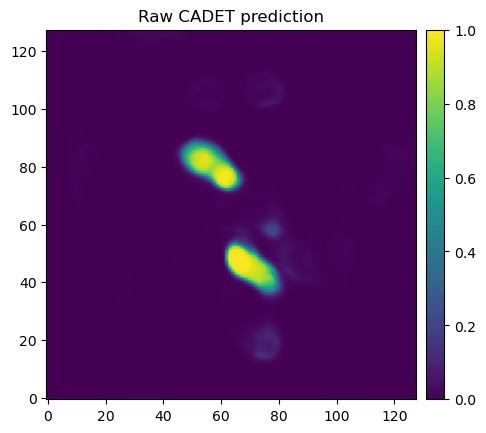

In [9]:
from matplotlib.colors import Normalize

plt.title("Raw CADET prediction")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

## **Shifting**

To suppress uncertainties connected with improper image centering as well as with activating slightly different neurons in the ***CADET*** model, the ***CADET*** pipeline includes the possibility to shift the centre of the input image by +/- 1 pixel in both X and Y directions. If `shift=True`, the final predictions is thus averaged from 9 differently shifted input images (the execution time is approximatelly 8 times longer).

When using the shifting option, the `make_prediction` function inputs 130x130 images. To obtain the binned image of this shape, the `shift=True` option also needs to be set in the `rebin` function. The shape of the resulting pixel-wise prediction is however still 128x128 pixels.

In [10]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456", shift=True)

data.shape

(130, 130)

In [11]:
%time pred = make_prediction(data, shift=True)

pred.shape

CPU times: user 55.8 s, sys: 508 ms, total: 56.3 s
Wall time: 5.22 s


(128, 128)

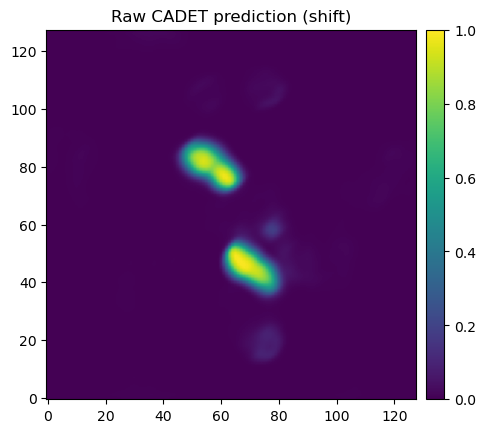

In [12]:
plt.title("Raw CADET prediction (shift)")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

# **Decompose**

To allow manipulation with individual X-ray cavities, the pixel-wise prediction obtained by the `make_prediction` function can be further decomposed into individual cavities using the DBSCAN algorithm (`decompose` function). However, prior to decomposition, the raw pixel-wise prediction must be thresholded. In order to simultaneously calibrate the volume error and the false positive rate, we introduced two discrimination thresholds (for more info see [Plšek et al. 2023](https://arxiv.org/abs/2304.05457)) with default values of 0.4 and 0.6, respectively. However, both discrimination thresholds are changeable and can be set to an arbitrary value between 0 and 1.

Arguments of the `decompose` function:\
`pred` - numpy array; pixel-wise prediction of shape (128, 128)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)\
`amin` - integer; minimal cavity area in units of pixels (optional, default: `amin=10`)

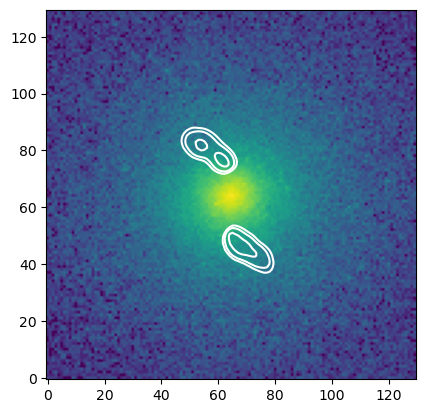

In [13]:
plt.imshow(np.log10(data+1), origin="lower");

plt.contour(pred, levels=[0.4, 0.6, 0.9], colors="white");

In [14]:
from pycadet import decompose

In [15]:
cavities = decompose(pred, th1=0.4, th2=0.6)

len(cavities), cavities[0].shape

(2, (128, 128))

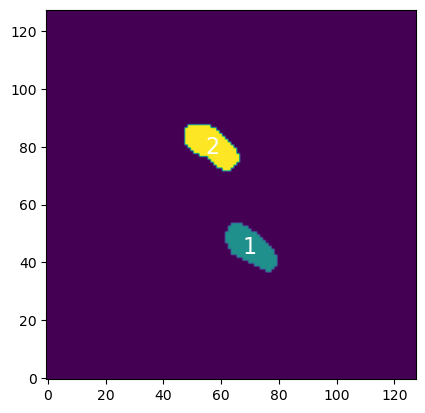

In [16]:
cavs = np.zeros((128,128))
for i, cav in enumerate(cavities):
    cavs += (i+1) * np.where(cav > 0, 1, 0)

plt.imshow(cavs, origin="lower")
for i, cav in enumerate(cavities):
    plt.text(*center_of_mass(cav)[::-1], i+1, fontsize=16, ha="center", va="center", c="w")

# **Make 3D cavity**

The decomposed cavities can be turned into a 3D cavity model using a `make_3D_cavity` function. The 3D models of X-ray cavities are created under the assumption of rotational symmetry along the direction from the galactic centre towards the centre of the cavity. The depth of the cavity at each point along this direction is then assumed to be equal to its width. The output of the `make_3D_cavity` function is a 3D matrix of shape (128, 128, 128) and the resulting 3D cavity model can be saved in the `.npy` format and can be used for further calculations (e.g. cavity energy estimation).

Arguments of the `make_3D_cavity` function:\
`cavity` - numpy array, individual cavity matrices

In [17]:
from pycadet import make_3D_cavity

In [18]:
cube1 = make_3D_cavity(cavities[0], rotate_back=True)
cube2 = make_3D_cavity(cavities[1], rotate_back=True)
cube = cube1 + cube2
cubes = [cube1, cube2]

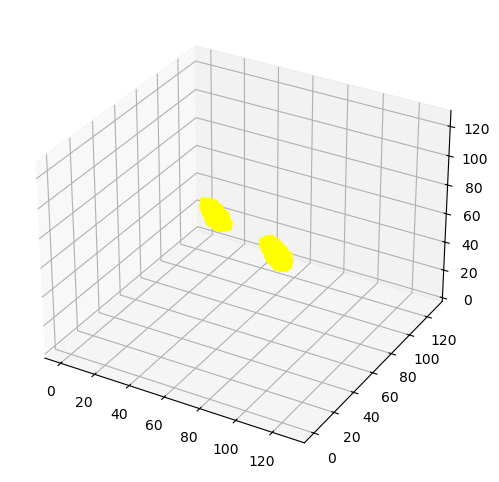

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(cube, edgecolor="yellow", facecolors="yellow", alpha=0.5);

## **Cavity areas & volumes**

In [20]:
# Get angular size of 1 pixel from the WCS
angular_scale = wcs.pixel_scale_matrix[1,1] * 3600

for i, cav, cube in zip(range(len(cavities)), cavities, cubes):
    print(f"Cavity {i+1}")
    print(f"area: {np.sum(cav):.0f} px²")
    print(f"area: {np.sum(cav)*angular_scale**2:.0f} arcsec²")
    print(f"volume: {np.sum(cube):.0f} px²")
    print(f"volume: {np.sum(cube)*angular_scale**3:.0f} arcsec³ (rotated)")
    print(f"volume: {4 / 3 / np.sqrt(np.pi) * (np.sum(cav)*angular_scale**2)**(3/2):.0f} arcsec³ (from area)\n")

Cavity 1
area: 132 px²
area: 128 arcsec²
volume: 1090 px²
volume: 1039 arcsec³ (rotated)
volume: 1092 arcsec³ (from area)

Cavity 2
area: 135 px²
area: 131 arcsec²
volume: 1264 px²
volume: 1204 arcsec³ (rotated)
volume: 1129 arcsec³ (from area)



# **CADET pipeline**

The `pycadet` package also includes the full CADET pipeline. The pipeline takes an input image (`fname`), crops it on multiple scales specified by the `scales` parameter around central coordinates defined by the `ra` and `dec` parameters (uses centre of the image if not specified), and bins them to the desired shape (depending on the `shift` parameter). It then applies the CADET model to images of individual scales and decomposes the predictions into individual cavities.

The pipeline also creates a folder with the same name as the FITS file, and saves the corresponding pixel-wise as well as decomposed cavity predictions in FITS format, while also properly preserving the WCS coordinates. The pipeline also generates 3D representations of the cavities and saves them in the `.npy` format in the *cubes* folder. The pipeline also creates a PNG file showing the pixel-wise predictions for each scale as contours superimposed on the original images.

Arguments of the `CADET` function:
`fname` - string; name of the input file\
`scales` - list of integers; specifies the crop sizes (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)

In [21]:
from pycadet import CADET

---- Running CADET ----
Reading file: NGC4649.fits

Original image size: 529x529 pixels
Selected scales: [1, 2, 3, 4]

RA & DEC not specified.
Using the center of the image:
RA:  12:43:39.96 hours
DEC: 11:33:09.96 degrees

Creating directories:
NGC4649/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing the image on following scales:
128 pixels:  detected 2 cavities
256 pixels:  detected 2 cavities
384 pixels:  WARNING:tensorflow:5 out of the last 8 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa3d8e4d760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.o

scale                        128 pixels       256 pixels       384 pixels  \
cavity                                1     2          1     2          1   
area [px²]                          324   378        128   139         48   
area [arcsec²]                       78    91        123   135        105   
volume [px³]                       4930  5516        972  1144        224   
volume [arcsec³] (rotated)          587   657        926  1090        720   
volume [arcsec³] (from area)        523   658       1032  1174        814   

scale                              512 pixels  
cavity                           2          1  
area [px²]                      64         24  
area [arcsec²]                 139         94  
volume [px³]                   348         82  
volume [arcsec³] (rotated)    1119        625  
volume [arcsec³] (from area)  1232        686

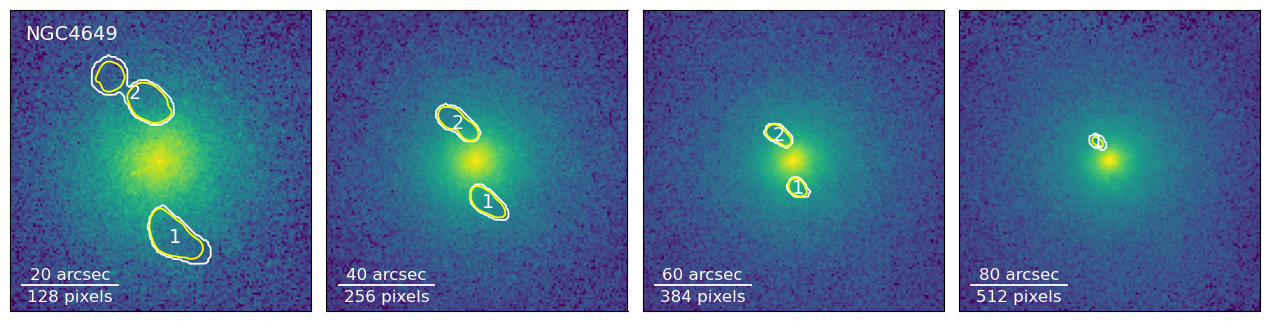

In [22]:
CADET("NGC4649.fits", scales=[1,2,3,4], th1=0.4, th2=0.6, shift=True)

---- Running CADET ----
Reading file: NGC4778.fits

Original image size: 2510x1916 pixels
Selected scales: [1, 2, 3, 4, 5]
RA:  12:53:05.6621 hours
DEC: -9:12:14.883 degrees

Creating directories:
NGC4778/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing the image on following scales:
128 pixels:  detected 2 cavities
256 pixels:  detected 2 cavities
384 pixels:  detected 3 cavities
512 pixels:  detected 3 cavities
640 pixels:  detected 3 cavities

Saving results:
NGC4778/cavity_properties.txt

area [px²] and volume [px³] are expressed in units of binned pixels
volume [arcsec³] (rotated) - calculated assuming rotational symmetry along the axis from galaxy center to cavity center
volume [arcsec³] (from area) - calculated from area assuming a sphere V ≈ 0.75 A^(3/2)



scale                        128 pixels      256 pixels        384 pixels  \
cavity                                1    2          1      2          1   
area [px²]                          983   63        299    892        165   
area [arcsec²]                      238   15        289    864        359   
volume [px³]                      27670  414       4508  20292       2310   
volume [arcsec³] (rotated)         3295   49       4295  19333       7428   
volume [arcsec³] (from area)       2763   44       3698  19089       5126   

scale                                      512 pixels              640 pixels  \
cavity                            2      3          1      2     3          1   
area [px²]                      479    267        102    317   142         76   
area [arcsec²]                 1045    582        396   1226   551        462   
volume [px³]                   8274   3346        994   4314  1110        556   
volume [arcsec³] (rotated)    26606  10759       7576  32882  8461       8277   
volume [arcsec³] (from area)  25397  10561       5921  32306  9736       7481   

scale                                      
cavity                            2     3  
area [px²]                      195    59  
area [arcsec²]                 1177   355  
volume [px³]                   2072   414  
volume [arcsec³] (rotated)    30846  6163  
volume [arcsec³] (from area)  30381  5033

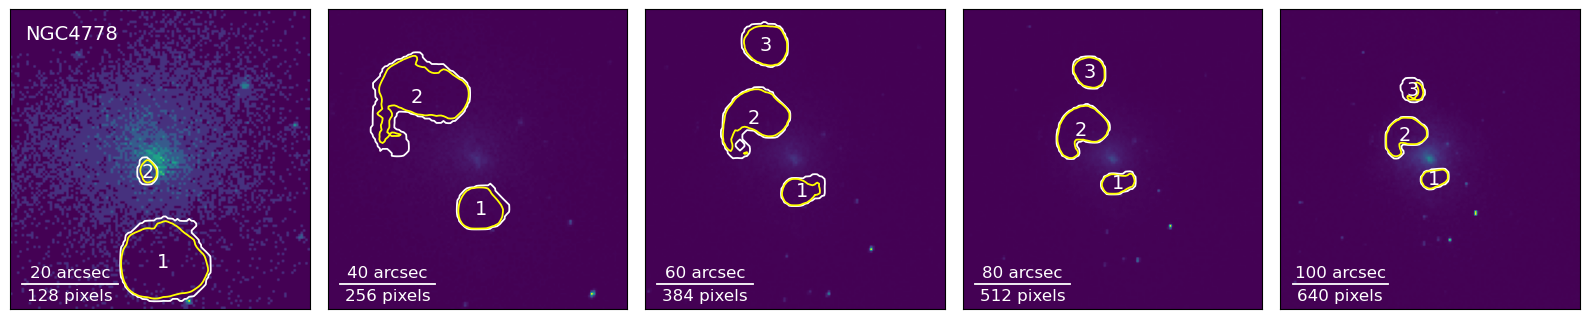

In [23]:
CADET("NGC4778.fits", scales=[1,2,3,4,5], ra="12:53:05.6621", dec="-9:12:14.883", th1=0.4, th2=0.7)